# Udacity Data Science Nanodegree - Project 1
## Author: Michael Vogan
### Goal: Use Seattle AirBnB data to analyze the most important determinants of high ratings

Dataset: https://www.kaggle.com/datasets/airbnb/seattle?resource=download&select=listings.csv

# Section 1: Business Understanding

## Questions

1) Are specific property attributes correlated with high ratings?

2) Do customers prefer Airbnb rentals in certain parts of Seattle?

3) What actions can a host take to get a high rating?


In [1]:
#Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Section 2: Data Understanding

In [2]:
#Load listing data
df = pd.read_csv("listings.csv")
df.set_index("id", drop = True, inplace = True)

In [3]:
# Keep only variables of interest
df = df[["host_since", "host_response_time", "host_response_rate", "host_acceptance_rate", "host_verifications", 
        "host_has_profile_pic", "host_identity_verified", "neighbourhood_group_cleansed", 
        "property_type", "room_type", "accommodates", "bathrooms", "bedrooms",
        "beds", "bed_type", "price", "guests_included", "extra_people", "minimum_nights",
        "maximum_nights", "calendar_updated", "availability_90", "availability_365",
        "first_review", "last_review", "review_scores_rating", 
        "instant_bookable", "cancellation_policy", "require_guest_profile_picture",
        "require_guest_phone_verification", "calculated_host_listings_count"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 241032 to 10208623
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_since                        3816 non-null   object 
 1   host_response_time                3295 non-null   object 
 2   host_response_rate                3295 non-null   object 
 3   host_acceptance_rate              3045 non-null   object 
 4   host_verifications                3818 non-null   object 
 5   host_has_profile_pic              3816 non-null   object 
 6   host_identity_verified            3816 non-null   object 
 7   neighbourhood_group_cleansed      3818 non-null   object 
 8   property_type                     3817 non-null   object 
 9   room_type                         3818 non-null   object 
 10  accommodates                      3818 non-null   int64  
 11  bathrooms                         3802 non-null   float64
 1

# Section 3: Data Preparation

In [4]:
df_clean = df.copy()

#Feature engineering

# Create dates
time_vars = df_clean[["host_since", "first_review", "last_review"]].apply(
    lambda x: pd.to_datetime(x))
df_clean[["host_since", "first_review", "last_review"]] = time_vars
df_clean["review_time"] = df_clean["last_review"] - df_clean["first_review"]
df_clean["review_time"] = df_clean["review_time"].dt.days
df_clean["host_age"] = df_clean["last_review"] - df_clean["host_since"]
df_clean["host_age"] = df_clean["host_age"].dt.days

# Convert price to number
df_clean["price"] = pd.to_numeric(df_clean["price"].apply(lambda x: x.replace('$', '').replace(',','')))

# Clean rate vars
df_clean["host_response_rate"] = pd.to_numeric(df_clean["host_response_rate"].apply(
    lambda x: x.replace('%', '') if pd.notnull(x) else x))
df_clean["host_acceptance_rate"] = pd.to_numeric(df_clean["host_acceptance_rate"].apply(
    lambda x: x.replace('%', '') if pd.notnull(x) else x))

# Create host number of identity verifications
df_clean["n_verifications"] = df_clean["host_verifications"].apply(
    lambda x: len(x.split(",")))

df_clean.drop(["host_verifications", "first_review", "last_review", "host_since"], axis = 1, inplace = True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 241032 to 10208623
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_response_time                3295 non-null   object 
 1   host_response_rate                3295 non-null   float64
 2   host_acceptance_rate              3045 non-null   float64
 3   host_has_profile_pic              3816 non-null   object 
 4   host_identity_verified            3816 non-null   object 
 5   neighbourhood_group_cleansed      3818 non-null   object 
 6   property_type                     3817 non-null   object 
 7   room_type                         3818 non-null   object 
 8   accommodates                      3818 non-null   int64  
 9   bathrooms                         3802 non-null   float64
 10  bedrooms                          3812 non-null   float64
 11  beds                              3817 non-null   float64
 1

In [5]:
#drop/impute numeric missing values

#Drop missing target variable - don't want to impute since it is the focus of study
df_clean = df_clean.dropna(subset = ["review_scores_rating"])

#Impute all other missing numeric variables with column mean
#This is appropriate because missing values are missing at random
num_vars = df_clean.select_dtypes(["int64", "float64"]).columns
df_clean.loc[:,num_vars] = df_clean[num_vars].fillna(df_clean[num_vars].mean().iloc[0])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3171 entries, 241032 to 8902327
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_response_time                2859 non-null   object 
 1   host_response_rate                3171 non-null   float64
 2   host_acceptance_rate              3171 non-null   float64
 3   host_has_profile_pic              3171 non-null   object 
 4   host_identity_verified            3171 non-null   object 
 5   neighbourhood_group_cleansed      3171 non-null   object 
 6   property_type                     3171 non-null   object 
 7   room_type                         3171 non-null   object 
 8   accommodates                      3171 non-null   int64  
 9   bathrooms                         3171 non-null   float64
 10  bedrooms                          3171 non-null   float64
 11  beds                              3171 non-null   float64
 12

## Section 3.1: Descriptive Analysis

       host_response_rate  host_acceptance_rate  accommodates    bathrooms  \
count         3171.000000           3171.000000   3171.000000  3171.000000   
mean            95.223155             99.249904      3.384421     1.614531   
std             10.712557              2.454646      1.991495     5.800740   
min             17.000000              0.000000      1.000000     0.000000   
25%             95.223155            100.000000      2.000000     1.000000   
50%            100.000000            100.000000      3.000000     1.000000   
75%            100.000000            100.000000      4.000000     1.000000   
max            100.000000            100.000000     16.000000    95.223155   

          bedrooms         beds        price  guests_included  minimum_nights  \
count  3171.000000  3171.000000  3171.000000      3171.000000     3171.000000   
mean      1.480397     1.742353   126.802586         1.708294        2.395774   
std       4.174665     1.154951    90.007172         1

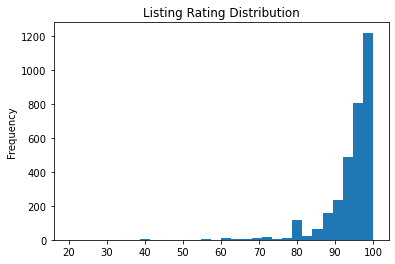

In [6]:
# Evaluate target variable distribution
# Ratings distribution very left skewed
print(df_clean.describe())
df_clean["review_scores_rating"].plot(kind = "hist", title ="Listing Rating Distribution", bins = 30)

## Question 1: Are specific property attributes correlated with high ratings?

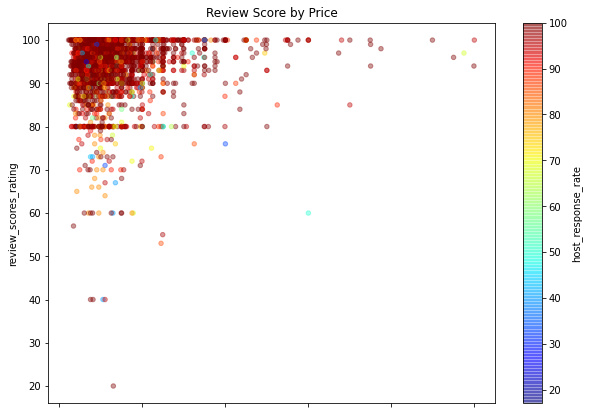

In [7]:
# Plot relationship between price and reviews
# Ratings are heteroskedastic w/r/t price. Low ratings and low prices
# are assocated with slower host response rates
df_clean.plot(kind = 'scatter', x = "price", y = "review_scores_rating", c = "host_response_rate", figsize =(10,7),
         cmap = plt.get_cmap("jet"), colorbar = True, alpha = 0.4, title = "Review Score by Price")

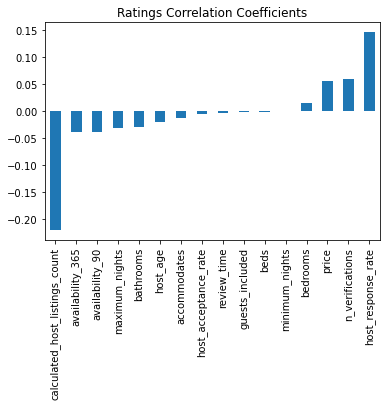

In [8]:
# Simple ratings correlation to other numeric features
# Price and bedrooms are only listing attributes meaningfully correlated with review score
df_clean.corr()["review_scores_rating"].drop("review_scores_rating").sort_values().plot.bar(title = "Ratings Correlation Coefficients")

## Question 1 Summary

Question - Are specific property attributes correlated with high ratings?

Analysis - The first question uses exploratory data analysis to see if certain listing attributes are highly correlated with ratings. Calculating simple correlation coefficients between ratings and other numeric columns, we see that price is the only listing feature significantly correlated with ratings. Interestingly, we also see that ratings are also heteroscedastic w/r/t price, meaning that low priced units have higher ratings variation than higher priced units. 

Conclusion - This intuitively makes sense as higher priced units are indicative of higher quality. However, this does not control for variation caused by other features, so this effect may be biased compared to the coefficient estimated using the model in Section 5.



## Question 2: Do customers prefer Airbnb rentals in certain parts of Seattle?

In [9]:
# Calculate average rating by neighborhood
# University district has lowest reviews but also very high average listings/host
df_clean.groupby("neighbourhood_group_cleansed").mean()[["price", "calculated_host_listings_count",
                    "host_response_rate", "review_scores_rating"]].sort_values(by = "review_scores_rating", ascending = False)

,price,calculated_host_listings_count,host_response_rate,review_scores_rating
neighbourhood_group_cleansed,,,,
Central Area,126.119122,1.793103,94.627764,96.009404
West Seattle,128.993827,1.617284,97.222326,95.864198
Delridge,81.369231,1.338462,97.424032,95.861538
Ballard,123.647668,1.709845,95.886654,95.533679
Queen Anne,161.402439,1.670732,94.973932,95.443089
Seward Park,108.102564,3.205128,93.247935,95.025641
Rainier Valley,90.358209,2.432836,96.261257,94.731343
Northgate,90.153846,1.830769,95.955627,94.692308
Other neighborhoods,118.004573,2.832317,95.614759,94.562500


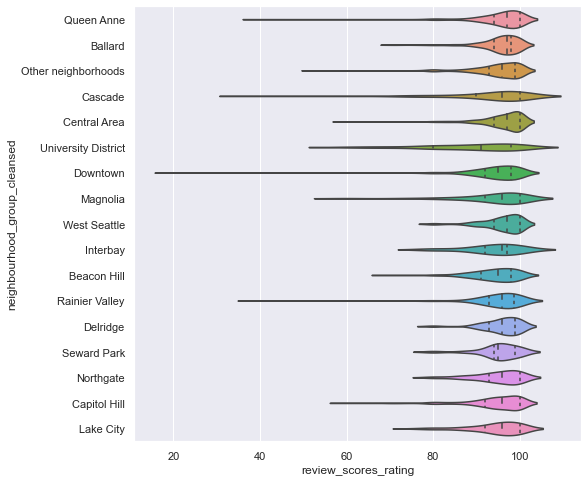

In [10]:
# Plot ratings distribution by neighborhood
# Cascade and University District have the most mass in left tail,
# but every neighborhood has at least some very low reviews
sns.set(rc={"figure.figsize":(8, 8)})
sns.violinplot(x = "review_scores_rating", y = "neighbourhood_group_cleansed",data = df_clean, inner="quartile")


## Question 2 Summary

Question - Do customers prefer Airbnb rentals in certain parts of Seattle?

Analysis - The second question examines the ratings distributions by neighborhood. The table above shows that Downtown, Magnolia, Interbay, Casacade, and University District neighboorhoods all have average ratings below Seattle's average. It is noteworthy that Interbay and University District both have low priced listings while Downtown, Magnolia, and Cascade has high priced listings. This suggests that price varation by neighborhood is not the main reason for low ratings. University City is especially interesting because of the extremely high listings/host count, which is shown above to have a strong negative correlation to ratings. The accordian plots show that every neighborhood has at least some very bad ratings well below their neighborhood averages. 

Conclusion - There does seem to be variation in reviews by neighboorhood that isn't explained by price. Other features such as host listing count, especially in the University District, could however contribute to the difference in average ratings observed in the table above. The model in Section 5 will help to isolate the marginal neighborhood effect holding everything else constant. 

In [11]:
# Create dummy variables
df_clean = df_clean.dropna()

In [12]:
cat_vars = df_clean.select_dtypes("object").columns

for v in cat_vars:
    print("{0}: {1}".format(v, len(df_clean[v].value_counts())))

host_response_time: 4
host_has_profile_pic: 2
host_identity_verified: 2
neighbourhood_group_cleansed: 17
property_type: 16
room_type: 3
bed_type: 5
extra_people: 43
calendar_updated: 26
instant_bookable: 2
cancellation_policy: 3
require_guest_profile_picture: 2
require_guest_phone_verification: 2


In [13]:
def gen_dummies(df, cat_vars):
    """
    Function to generate dummy variables for modeling
    
    Args: 
        df - dataframe with categorical variables
        cat_vars - list of categorical variable index names
        
    Returns:
        df_dum - dataframe with dummies included
    """
    df_dum = df.copy()
    
    for v in cat_vars:
        dummies = pd.get_dummies(df_dum[v], prefix = v)
        df_dum = df_dum.drop(columns = [v])
        df_dum = pd.concat([df_dum, dummies], axis = 1)
    
    return df_dum
    

In [14]:
cat_vars = df_clean.select_dtypes("object").columns

df_clean = gen_dummies(df_clean, cat_vars)

# Section 4: Data Modeling

In [15]:
#Train/test split and transform all features

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y = df_clean["review_scores_rating"]
X = df_clean.drop(columns = "review_scores_rating")

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
print("X_train: {0}, y_train: {1}, X_test: {2}, y_test: {3}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train: (1915, 143), y_train: (1915,), X_test: (944, 143), y_test: (944,)


In [17]:
#Fit model, pick best alpha using cross validation
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error

clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], store_cv_values = True)
clf.fit(X_train, y_train)
print(clf.cv_values_)

[[ 21.79196331  21.79183644  21.79056818  21.77792508]
 [ 22.65701498  22.6571084   22.65804248  22.6673722 ]
 [ 21.79427311  21.79432259  21.79481661  21.79968232]
 ...
 [  3.15256867   3.15251287   3.15195515   3.14640969]
 [225.02929891 225.02954868 225.03204616 225.05700073]
 [109.09797177 109.09788495 109.0970175  109.08841562]]


# Section 5: Evaluate Results

## Question 3: What actions can a host take to get a high rating?

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


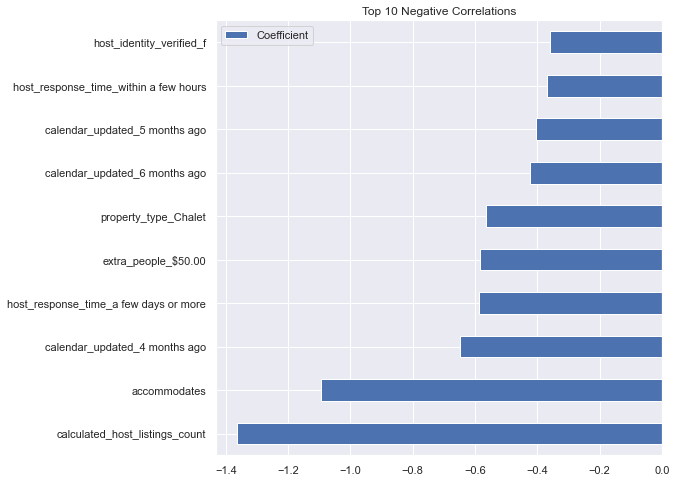

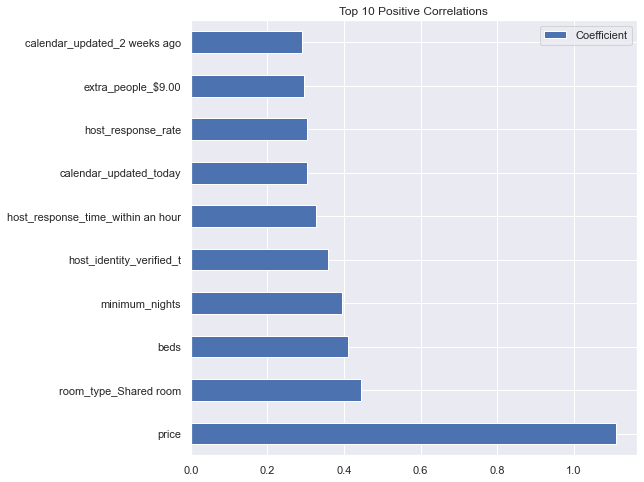

In [18]:
# Plot Top 10 features with positive/negative correlations
# Host features are highly correlated with review score
# Price is only listing features that is meaningfully correlated with ratings
coef_df = pd.DataFrame(data = clf.coef_, index = X.columns)
coef_df = coef_df.rename({0: "Coefficient"}, axis = "columns")
print(coef_df.sort_values(by = "Coefficient").head(10).plot.barh(title = "Top 10 Negative Correlations"))
print(coef_df.sort_values(by = "Coefficient", ascending = False).head(10).plot.barh(title = "Top 10 Positive Correlations"))

## Question 3 Summary
Question - What actions can a host take to get a high rating?

Analysis - The third question is the main question of the analysis. The ridge regression is intended to isolate the marginal impact of each feature to ratings in order to accurately measure how host behavior influences the final rating. Prior to model estimation, I transformed all features using a standard scalar to make sure the coefficients were comparable. The results show that price is still the main feature that impacts ratings, but many host features such as identity verified, response time, response rate, calendar updated, etc. are also very important. Listings per host still shows up has having a strong negative impact on ratings. However, neighborhood dummies to not appear in the top feature list, which suggests that the difference in average ratings is explained by variation in features across the neighborhoods. 

Conclusion - Price is clearly a strong signal of listing quality, but host actions are equally important. This make sense - a host that is responsible, timely, and manages few properties will most likely provide a better experience than one who doesn't. The analysis is encouraging in that even if the listing isn't the biggest or highest quality, a great host can make up for it. 

In [19]:
#Accuracy testing

y_train_pred = clf.predict(X_train)
y_train_pred[y_train_pred > 100] = 100
y_test_pred = clf.predict(X_test)
y_test_pred[y_test_pred > 100] = 100

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Train MAE: {0}, Test MAE: {1}".format(train_mae, test_mae))

Train MAE: 4.055562035951538, Test MAE: 4.201121303996616
